In [2]:
import pandas as pd
from pandasql import sqldf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
results_df = pd.read_csv('results_df.csv')
results_df.loc[results_df['model_name'] == 'extremelyfastdecisiontreeclassifier', 'model_name'] = 'EFDT'
results_df.loc[results_df['model_name'] == 'hoeffdingtreeclassifier', 'model_name'] = 'HT'

In [18]:
results_df

,model_name,drift_name,feature_selector_name,learning_threshold,iteration,accuracy,drifts_detected,model_args,ticker
0,HT,adwin,selectkbest,100,1,0.516,0,"grace_period=100, max_depth=4, delta=0.001",AAPL
1,HT,adwin,selectkbest,100,2,0.516,0,"grace_period=100, max_depth=4, delta=0.001",AAPL
2,HT,adwin,selectkbest,100,3,0.516,0,"grace_period=100, max_depth=4, delta=0.001",AAPL
3,HT,adwin,selectkbest,100,4,0.516,0,"grace_period=100, max_depth=4, delta=0.001",AAPL
4,HT,adwin,selectkbest,100,5,0.516,0,"grace_period=100, max_depth=4, delta=0.001",AAPL
...,...,...,...,...,...,...,...,...,...
15745,randomforest,bollingerband,selectkbest_sklearn,2000,1,0.507,7,"n_estimators=300, max_depth=20, max_features=log2",AAPL
15746,randomforest,bollingerband,selectkbest_sklearn,2000,2,0.510,7,"n_estimators=300, max_depth=20, max_features=log2",AAPL
15747,randomforest,bollingerband,selectkbest_sklearn,2000,3,0.512,7,"n_estimators=300, max_depth=20, max_features=log2",AAPL
15748,randomforest,bollingerband,selectkbest_sklearn,2000,4,0.510,7,"n_estimators=300, max_depth=20, max_features=log2",AAPL


In [14]:
sqldf('''

select model_name
from results_df
group by model_name

''')

,model_name
0,EFDT
1,HT
2,mlp
3,randomforest
4,xgboost


### MODELS OVERVIEW

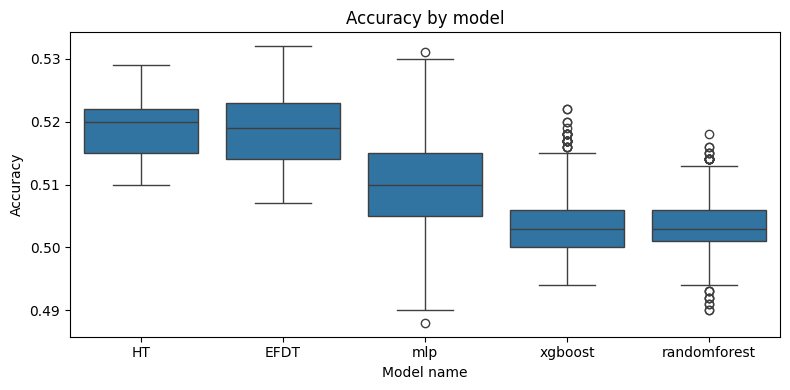

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='model_name', y="accuracy", data=results_df)
plt.title("Accuracy by model")
# plt.xticks(rotation=45)
plt.xlabel("Model name")
plt.ylabel("Accuracy")
plt.tight_layout()
# plt.savefig('result_df_images_to_report/models_comparison_accuracy.png')
plt.show()


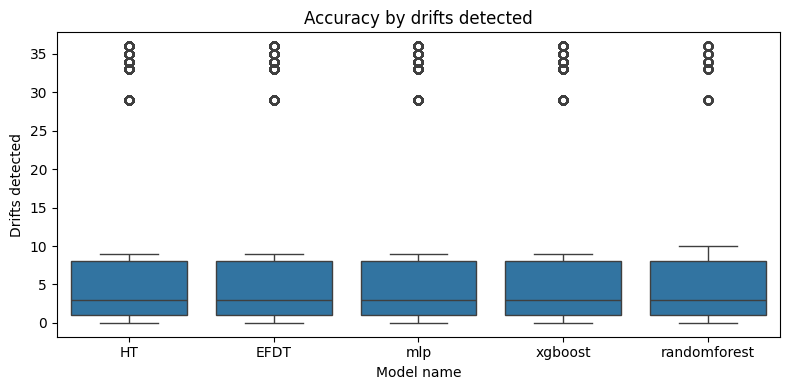

In [16]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='model_name', y="drifts_detected", data=results_df)
plt.title("Accuracy by drifts detected")
# plt.xticks(rotation=45)
plt.xlabel("Model name")
plt.ylabel("Drifts detected")
plt.tight_layout()
# plt.savefig('result_df_images_to_report/models_comparison_drifts_detected.png')
plt.show()


In [ ]:
def model_overview(model_name, args_limit=10, to_latex=False):
    
    # drift_comparison = sqldf('''

    #     select model_name, drift_name, avg(drifts_detected), avg(accuracy), max(accuracy)

    #     from results_df
    #     where model_name = '{model_name}'

    #     group by model_name, drift_name
    #     order by avg(accuracy) desc
    # '''.format(model_name=model_name))

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    model_results = results_df.loc[results_df['model_name'] == model_name]

    sns.boxplot(x='drift_name', y="accuracy", data=model_results, ax=axes[0])
    axes[0].set_title("Accuracy by drift detector - {model_name}".format(model_name=model_name))
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_xlabel("Drift Detector")
    axes[0].set_ylabel("Accuracy")

    sns.boxplot(x='drift_name', y="drifts_detected", data=model_results, ax=axes[1])
    axes[1].set_title("Drifts Detected by Drift Detector - {model_name}".format(model_name=model_name))
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].set_xlabel("Drift Detector")
    axes[1].set_ylabel("Drifts Detected")

    plt.tight_layout()
    if to_latex:
        plt.savefig('result_df_images_to_report/drift_comparison_{model_name}.png'.format(model_name=model_name))
    else:
        plt.show()

    plt.figure(figsize=(8, 4))

    sns.boxplot(x='learning_threshold', y="accuracy", data=model_results)
    plt.title("Accuracy by learning threshold")
    # plt.xticks(rotation=45)
    plt.xlabel("Learning threshold")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    if to_latex:
        plt.savefig('result_df_images_to_report/learning_threshold_comparison_{model_name}.png'.format(model_name=model_name))
    else:
        plt.show()

    model_args_comparison = sqldf('''

        select model_args, learning_threshold, drift_name, avg(drifts_detected), avg(accuracy), max(accuracy)

        from results_df
        where model_name = '{model_name}'
        --and drift_name != 'dummydriftdetector'

        group by model_args, learning_threshold, drift_name
        order by avg(accuracy) desc
    '''.format(model_name=model_name)
    )

    split_args = model_args_comparison['model_args'].str.split(',s*')
    param_dicts = split_args.apply(
    lambda pairs: dict(pair.split('=') for pair in pairs if '=' in pair)
        )
    args_df = pd.json_normalize(param_dicts)
    model_args_comparison = pd.concat([args_df, 
                                       model_args_comparison.loc[:,['learning_threshold', 'drift_name',  'avg(drifts_detected)', 'avg(accuracy)', 'max(accuracy)']]], axis=1)

    model_args_comparison = pd.concat([model_args_comparison.iloc[:args_limit//2,:],
                                       model_args_comparison.iloc[-args_limit//2:,:]])

    if to_latex:
        # print("\n% Drift Comparison Table - {model_name}".format(model_name=model_name))
        # print(drift_comparison.to_latex(index=False, float_format="%.3f").replace('_', r'\_'))
        print("\n% Model Args Comparison Table - {model_name}".format(model_name=model_name))
        model_args_comparison.rename(columns={'learning_threshold': 'LT', 
                                              'avg(drifts_detected)': 'avg(drifts)',
                                              'drift_name': 'drift',
                                              'avg(accuracy)': 'avg(acc)',
                                              'max(accuracy)': 'max(acc)'}, inplace=True)
        latex_model_args = "\\begin{table}[ht]\n" + \
                            model_args_comparison.to_latex(index=False, float_format="%.3f").replace('_', r'\_') + \
                            f"\\caption{{Model Args Comparison Table - {model_name} ({args_limit//2} best and worst)}}\n\\end{{table}}"
        print(latex_model_args)

    else:
        # display(drift_comparison)
        display(model_args_comparison)

for model_name in results_df['model_name'].unique().tolist():
    model_overview(model_name, 14, True)


% Model Args Comparison Table - HT
\begin{table}[ht]
\begin{tabular}{lllrlrrr}
\toprule
grace\_period &  max\_depth &  delta & LT & drift & avg(drifts) & avg(acc) & max(acc) \\
\midrule
100 & 12 & 0.001 & 2000 & adwin & 0.000 & 0.529 & 0.529 \\
100 & 12 & 0.001 & 2000 & pagehinkley & 0.000 & 0.529 & 0.529 \\
100 & 12 & 1e-05 & 2000 & adwin & 0.000 & 0.529 & 0.529 \\
100 & 12 & 1e-05 & 2000 & pagehinkley & 0.000 & 0.529 & 0.529 \\
100 & 12 & 1e-07 & 2000 & adwin & 0.000 & 0.529 & 0.529 \\
100 & 12 & 1e-07 & 2000 & pagehinkley & 0.000 & 0.529 & 0.529 \\
100 & 4 & 0.001 & 2000 & adwin & 0.000 & 0.529 & 0.529 \\
300 & 12 & 1e-07 & 200 & dummydriftdetector & 35.000 & 0.510 & 0.510 \\
300 & 4 & 0.001 & 200 & dummydriftdetector & 35.000 & 0.510 & 0.510 \\
300 & 4 & 1e-05 & 200 & dummydriftdetector & 35.000 & 0.510 & 0.510 \\
300 & 4 & 1e-07 & 200 & dummydriftdetector & 35.000 & 0.510 & 0.510 \\
300 & 8 & 0.001 & 200 & dummydriftdetector & 35.000 & 0.510 & 0.510 \\
300 & 8 & 1e-05 & 200 & dum

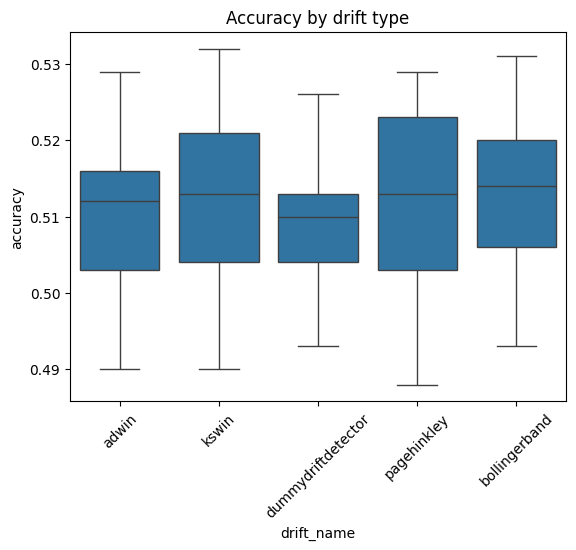

In [44]:
sns.boxplot(x='drift_name', y="accuracy", data=results_df)
plt.title("Accuracy by drift type")
plt.xticks(rotation=45)
# plt.tight_layout()
plt.show()

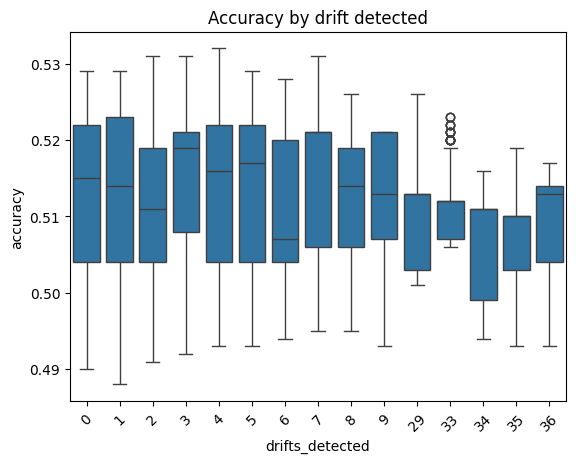

In [25]:
sns.boxplot(x='drifts_detected', y="accuracy", data=results_df)
plt.title("Accuracy by drift detected")
plt.xticks(rotation=45)
# plt.tight_layout()
plt.show()

In [22]:
', '.join(results_df.columns.tolist())

'model_name, drift_name, feature_selector_name, learning_threshold, iteration, accuracy, drifts_detected, model_args, ticker'

In [27]:
sqldf('''

select model_name, drift_name, feature_selector_name, learning_threshold, avg(accuracy), model_args
from results_df
where model_name = 'HT'
group by model_name, drift_name, feature_selector_name, learning_threshold, accuracy,  model_args
order by accuracy desc
''')

,model_name,drift_name,feature_selector_name,learning_threshold,avg(accuracy),model_args
0,HT,adwin,selectkbest,2000,0.529,"grace_period=100, max_depth=12, delta=0.001"
1,HT,adwin,selectkbest,2000,0.529,"grace_period=100, max_depth=12, delta=1e-05"
2,HT,adwin,selectkbest,2000,0.529,"grace_period=100, max_depth=12, delta=1e-07"
3,HT,adwin,selectkbest,2000,0.529,"grace_period=100, max_depth=4, delta=0.001"
4,HT,adwin,selectkbest,2000,0.529,"grace_period=100, max_depth=4, delta=1e-05"
...,...,...,...,...,...,...
1026,HT,dummydriftdetector,selectkbest,200,0.510,"grace_period=300, max_depth=4, delta=1e-05"
1027,HT,dummydriftdetector,selectkbest,200,0.510,"grace_period=300, max_depth=4, delta=1e-07"
1028,HT,dummydriftdetector,selectkbest,200,0.510,"grace_period=300, max_depth=8, delta=0.001"
1029,HT,dummydriftdetector,selectkbest,200,0.510,"grace_period=300, max_depth=8, delta=1e-05"
